# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# Предисловие

Проект оказался жутко объёмным и честно говоря тяжелым, я даже предположу, что он "такой" чтобы отсеять тех кто действительно хочет и тех кто пришел за новыми эмоциями. Тут их было прям, достаточно. Разница с предыдущими проектами - колоссальная. В виду того, что это по факту первый проект, который выполняется полностью автономно (без подсказок и автоматизации, а также рекомендаций по структуре, как было с предыдущими), вероятно, здесь периодически могут быть дублирующие сведения. Частично аномальные значения я обработал на этапе предобработки, частично, в ИАД. Я не стал удалять проделанную работу из предобработки.
Поэтому эти этапы, по части графиков частично дублируются. Честно говоря, не знаю насколько это "нормально"/"плохо". 

# План работы:
- произвести первичное ознакомление с данными;
- провести предобработку (удалить/заполнить пропуски, посмотреть на распределение величин);
- провести исследовательский анализ данных (обработать аномальные значения, ответить на поставленные в исследовании вопросы);
- добавить недостающие столбцы;
- изучить зависимости ценообразования от остальных параметров (посчитать зависимости, построить графики);
- написать выводы.

### Откройте файл с данными и изучите общую информацию

#### Импортируем необходимые библиотеки и откроем файл, запишем его в датафрейм df:

In [1]:
import pandas as pd # импортируем pandas
import matplotlib.pyplot as plt #импортируем matplotlib
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #разобьем данные на столбцы с помощью параметра sep='\t', 
#чтобы они стали читаемы

#### Изучим данные:

##### Внешний осмотр датафрейма

In [2]:
print(df.columns) #посомтрим количество и название колонок
print()
print(df.head(5)) #посмотрим первые 5 строк таблицы

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1      

##### Посмотрим общую информацию о типе данных в столбцах

In [3]:
df.info() # применим метод info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

##### Построим гистограммы к столбцам с численными значениями

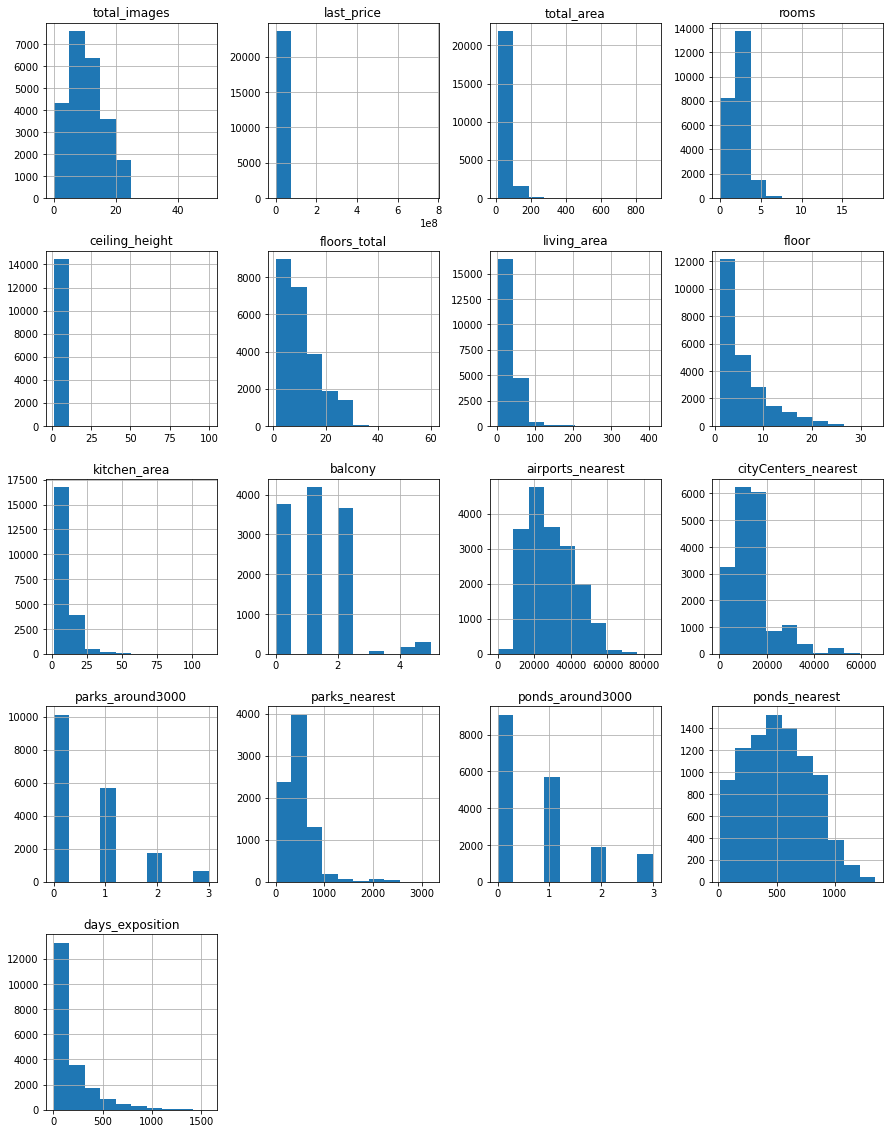

In [4]:
df.hist(figsize=(15, 20)) #построим гистограммы столбцов с численными значениями в соответствии с заданием
plt.show() # эта команда убирает странные надписи типа <AxesSubplot:> поэтому здесь и далее я буду ей пользоваться

##### Добавим небольшой экспресс-анализ содержимого в столбцах

Здесь посмотрим наличие пропусков и оценим количество уникальных значений:

In [5]:
for column in df.columns: # Напишем цикл и пройдемся по каждому столбцу
    print('Название столбца', column, 'Тип данных:', df[column].dtype) #выведем название столбца и тип его данных
    if len(df[column].unique())>15: #установим предел для вывода уникальных значений, так чтобы не перегружать экран,
        # если уникальных значений слишком много выведем их количество
        print('Множество уникальных значений в столбце:', len(df[column].unique())) #если значений меньше 15, то просто выведем их 
    else:
        print('Множество уникальных значений в столбце', df[column].unique())
    print('Количество пропусков', df[column].isna().sum())
    print()

Название столбца total_images Тип данных: int64
Множество уникальных значений в столбце: 38
Количество пропусков 0

Название столбца last_price Тип данных: float64
Множество уникальных значений в столбце: 2978
Количество пропусков 0

Название столбца total_area Тип данных: float64
Множество уникальных значений в столбце: 2182
Количество пропусков 0

Название столбца first_day_exposition Тип данных: object
Множество уникальных значений в столбце: 1491
Количество пропусков 0

Название столбца rooms Тип данных: int64
Множество уникальных значений в столбце: 17
Количество пропусков 0

Название столбца ceiling_height Тип данных: float64
Множество уникальных значений в столбце: 184
Количество пропусков 9195

Название столбца floors_total Тип данных: float64
Множество уникальных значений в столбце: 37
Количество пропусков 86

Название столбца living_area Тип данных: float64
Множество уникальных значений в столбце: 1783
Количество пропусков 1903

Название столбца floor Тип данных: int64
Множес

#### Вывод:
Для чтения и работы с данными импортированы библиотеки pandas и matplotlib. После загрузки и чтения файла, установлено, что в файле 22 колонки с параметрами и 23699 строк-данных о квартирах. Видно, что в данных есть пропуски, в некоторых колонках (is_apartment) их больше половины. Некоторые данные определились с ошибкой. К примеру, ponds_around3000 и parks_around3000 вполне могут быть целыми (int64). Также данные столбца first_day_exposition нуждаются в переводе в формат datetime. Эти и другие большие и мелкие недочеты нужно будет устранить на этапе предобработки данных.

### Выполните предобработку данных

Из предыдущего раздела, ясно что пропуски имеют следующие столбцы:
-ceiling_height
-floors_total
-living_area
-is_apartment
-kitchen_area
-balcony
-locality_name
-airports_nearest
-cityCenters_nearest
-parks_around3000
-parks_nearest
-ponds_around3000
-ponds_nearest
-days_exposition

In [6]:
print(df.shape) # для дальнейшего анализа выдем количество строк и столбцов
stroke_total = df.shape[0] # сохраним число строк "грязного" датафрейма до предобработки 
#в переменную stroke_total в конце посчитаем, сколько данных мы потеряли после "очистки".
print('Всего строк до обработки', stroke_total)

(23699, 22)
Всего строк до обработки 23699


#### Пройдемся подробнее по каждому столбцу, всего их 22:

##### total_images

Проведем первичный анализ, посмотрим пропуски и на всякий случай проверим на наличие отрицательных значений:

In [7]:
print('Количество пропусков:', df['total_images'].isna().sum()) #
print('Множество значений:', df['total_images'].unique())
print(df['total_images'].describe())

Количество пропусков: 0
Множество значений: [20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]
count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64


Вывод: total_images - не представляет особого интереса, пропусков в нем нет, отрицательных значений тоже, тип данных подходящий. Идем дальше.

##### last_price

Здесь, пожалуй, остановимся подробнее, это один из ключевых параметров исследования. Пропусков в нём нет, но хотелось бы подробнее посмотреть распределение цены.

In [8]:
print('Количество пропусков:', df['last_price'].isna().sum())
print('Множество значений:', df['last_price'].unique())
print(df['last_price'].describe())

Количество пропусков: 0
Множество значений: [13000000.  3350000.  5196000. ...  6151120. 21400000. 11475000.]
count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


Значение медианы и средней имеют достаточные различия. Вероятно, есть значения цен, которые существенно отличаются от остальных. Эти выбросы могут быть обусловлены как особенностями объекта продажи (жилье премиум-класса) так и ошибками. Для наглядности построим boxplot и возьмем на заметку данный столбец.

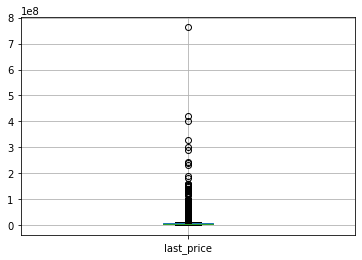

In [9]:
df.boxplot(column=['last_price']) # смотрим общий график
plt.show()

(0.0, 25000000.0)

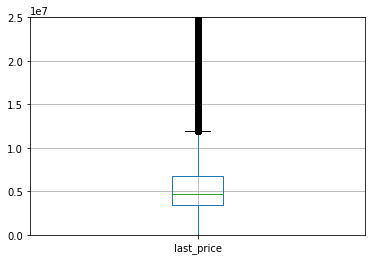

In [10]:
df.boxplot(column=['last_price']) # немного детализируем. Значения цены до ~12 миллионов попадают в нормальные значения,
#всё что выше - выбросы.
plt.ylim(0, 25000000)

Вывод: да, выбросов достаточно, возьмём это на заметку.

##### total_area

In [11]:
print('Количество пропусков:', df['total_area'].isna().sum())
print('Множество значений:', df['total_area'].unique())
print(df['total_area'].describe())
 

Количество пропусков: 0
Множество значений: [108.    40.4   56.   ...  66.86 133.81  76.75]
count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


Вывод: Пропусков нет, отрицательных значений тоже, тип данных определен верно. Медиана и среднее более менее близки. Смущает максимальное значение - 900м2. Квартиру 200-300 м2 еще можно себе представить (к примеру выкупили целиком этаж), но выброс в размере 900 м2 выглядит странно, кому а главное зачем понадобилось выкупить ~3 этажа в многоквартирном доме? Можно же купить дом к примеру...

##### first_day_exposition

In [12]:
print('Количество пропусков:', df['first_day_exposition'].isna().sum()) # количество пропусков

Количество пропусков: 0


Пропусков нет, данные определены строкой, их надо переделать в datetime. Займемся этим:

In [13]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# проверяем, что получилось:
print(df['first_day_exposition'].head(5))
print(df['first_day_exposition'].dtype)

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]
datetime64[ns]


Похоже, что все верно. Построим гистограмму для наглядности:

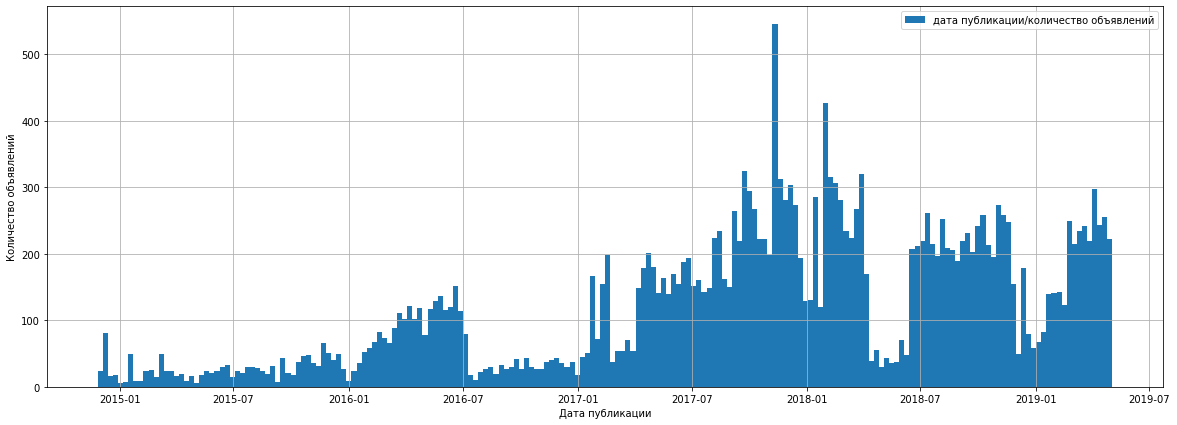

In [14]:
df['first_day_exposition'].hist(bins=200, figsize=(20,7), label = 'дата публикации/количество объявлений')
plt.xlabel('Дата публикации')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: Данные успешно преобразованы в формат datetime, что облегчит дальнейшую работу, пропусков данных не обнаружено, 
подозрительных выбросов нет.

##### rooms

In [15]:
print('Количество пропусков:', df['rooms'].isna().sum()) # Стандартные процедуры осмотра данных
print('Множество значений:', df['rooms'].unique())
print(df['rooms'].describe())

Количество пропусков: 0
Множество значений: [ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


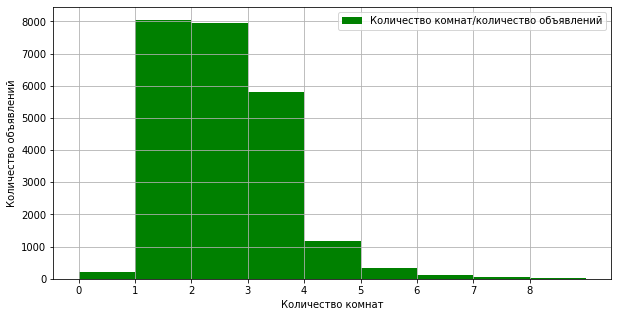

In [16]:
df['rooms'].hist(bins=range(0, 10, 1), figsize=(10,5), color='green', label='Количество комнат/количество объявлений')
plt.xticks(range(0, 9))
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: пропусков данных не обнаружено, тип данных определен верно, большинство квартир имеет от 1 до 5 комнат, 
есть несколько квартир с большим (до 19) количеством комнат. 
Возможно, эти записи - ошибки. Представить себе квартиру с 19 комнатами трудно, хотя, конечно, всё возможно.

##### ceiling_height

In [17]:
print('Количество пропусков:', df['ceiling_height'].isna().sum()) # стандартные процедуры
# команда print('Множество значений:', df['ceiling_height'].unique()) в принципе здесь не информативна, важнее следующая команда:
print(df['ceiling_height'].describe())

Количество пропусков: 9195
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


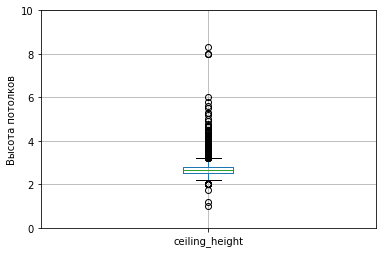

In [18]:
df.boxplot(column=['ceiling_height'])
plt.ylabel('Высота потолков')
plt.ylim(0, 10)
plt.show()

Вывод: Странные потолки высотой 1м (min) и 100м(max)... и не только эти. Вообще, потолки в квартирах менее 2,2 м и более 5 м выглядят нереальными. Вероятно, это ошибки. Надо пометить этот недочет.
Также в столбце пропущено 9195 значений. Скорее всего, на момент подачи объявления, люди просто не померили потолки, но нельзя исключать и техническую ошибку - значений пропущено достаточно много. В данном случае, их можно заполнить медианным значением - 2.65 м. Сделаем это:

In [19]:
# заполняем пропуски мединным значением
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
# проверим .что получилось:
print('Количество пропусков:', df.ceiling_height.isna().sum())

Количество пропусков: 0


Отлично, можно идти дальше.

##### floors_total

In [20]:
print('Тип данных:', df['floors_total'].dtype) # стандартные процедуры осмотра
print('Количество пропусков:', df['floors_total'].isna().sum())
print('Множество значений:', df['floors_total'].unique())
print(df['floors_total'].describe())

Тип данных: float64
Количество пропусков: 86
Множество значений: [16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]
count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


Так, первое что бросается в глаза - тип данных, этажей не может быть дробное число. Второе - количество пропусков, в остальном,
вроде бы существенных недостатков не видно.

In [21]:
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median()) # заполняем медианным значением
df['floors_total'] = df['floors_total'].astype(int) # меняем на целочисленный тип данных
# проверяем, что получилось
print('Количество пропусков:', df['floors_total'].isna().sum())
print('Тип данных:', df.floors_total.dtype)

Количество пропусков: 0
Тип данных: int64


При заполнении данных медианой, или же просто при ошибке заполнения колонок (менеджер перепутал колонки) могла 
возникнуть ошибка следующего характера. Этаж квартиры мог оказаться выше чем всего этажей в доме. Проверим это:

In [22]:
print('Этаж квартиры выше чем всего этажей:', df[df['floors_total'] < df['floor']].loc[:,'floors_total'].count())

Этаж квартиры выше чем всего этажей: 37


Так, есть ошибки. Хорошо, что их немного. в данном случае, есть два варианта - поменять значения floors_total и floor местами (там, где это необходимо). Или же просто дропнуть эти строки, благо, что их немного. Воспользуемся 1 вариантом.

In [23]:
df.loc[df['floors_total'] < df['floor'], 'floors_total'] = df.loc[df['floors_total'] < df['floor'], 'floor'] # делаем замену
print('Этаж квартиры выше чем всего этажей:', df[df['floors_total'] < df['floor']].loc[:,'floors_total'].count())

Этаж квартиры выше чем всего этажей: 0


Отлично, строим гистограмму :

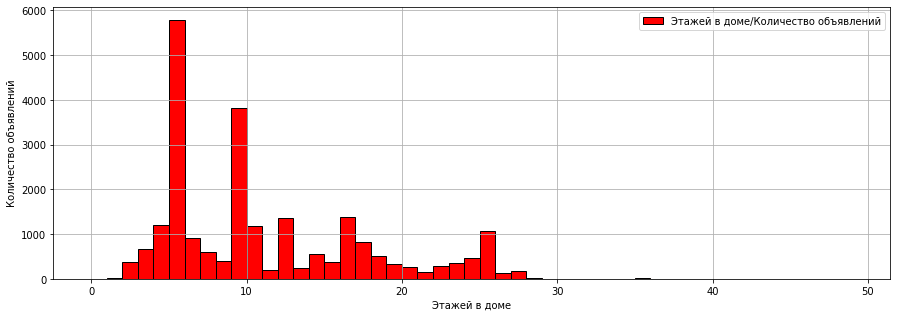

In [24]:
df['floors_total'].hist(bins=range(0, 50, 1), figsize=(15,5), color='red', edgecolor='black', label='Этажей в доме/Количество объявлений')
plt.xlabel('Этажей в доме')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: в данных было обнаружено 86 пропусков, которые были заменены медианным значением (9 этажей). Пропуски могли возникнуть либо в результате технической ошибки, либо менеджер могли пропустить соответствующие ячейки. Тип данных с дробного (вещественного) в данной колонке был заменен на целочисленный. Значения, где этаж квартире выше, чем всего этажей в доме были поменены местами. Таких данных было всего 37 из более чем 23000, даже если такой подход окажется неверным, вряд ли это серьёзно скажется на проводимом исследовании.

##### living_area

In [25]:
print('Тип данных:', df['living_area'].dtype) # стандартные процедуры осмотра
print('Количество пропусков:', df['living_area'].isna().sum())
print(df['living_area'].describe())

Тип данных: float64
Количество пропусков: 1903
count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64


Тип данных подходящий, а вот количество пропусков немаленькое. При этом, данный параметр один из ключевых в объявлении. Если пропуски заполнить медианой, то это может исказить результат анализа. Думаю, что несмотря на количество строчек, данные с пропусками придется всё-таки удалить.

In [26]:
df = df.dropna(subset=['living_area']) # удаляем строчки с пропусками
print('Количество пропусков в колонке living_area:', df['living_area'].isna().sum()) #Проверяем 
print('Строчек осталось после удаления', len(df))

Количество пропусков в колонке living_area: 0
Строчек осталось после удаления 21796


Всё верно, 23699-1903 = 21796. Все строки с пропусками удалены. Построим гистограмму прощади квартир:

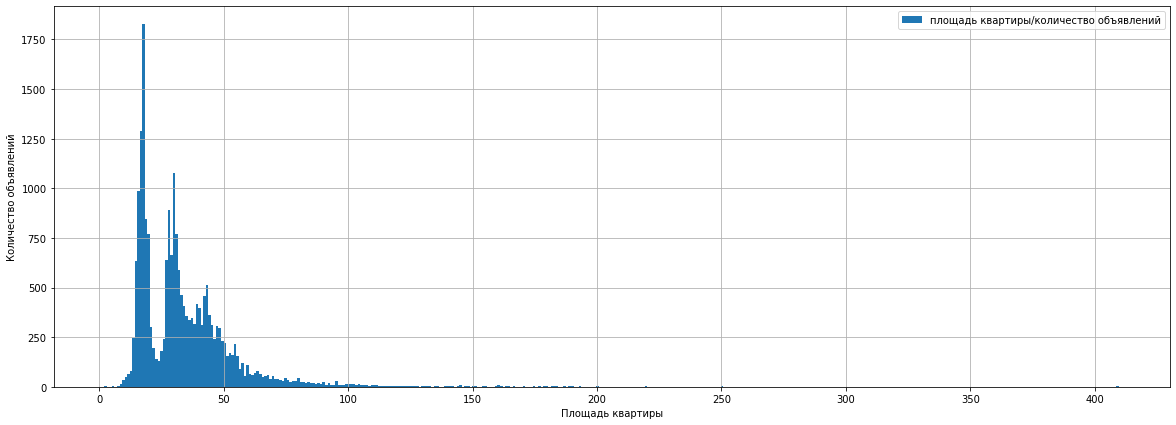

In [27]:
df['living_area'].hist(bins=400, figsize = (20, 7), label = 'площадь квартиры/количество объявлений')
plt.xlabel('Площадь квартиры')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Гистограмма слабо отражает выбросы, построим еще boxplot:

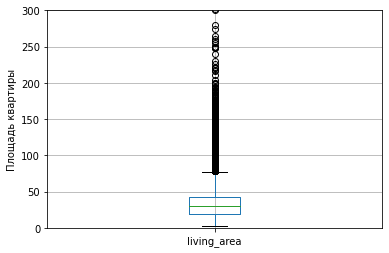

In [28]:
df.boxplot(column=['living_area'])
plt.ylabel('Площадь квартиры')
plt.ylim(0, 300)
plt.show()

Вывод: Несмотря на то, что по графику boxplot граница нормальных значений по площади находится где-то до 80 м2, исходя из жизненного опыта, предположу, что квартиры с площадью до 100-150 м2 - вполне себе реальны, а вот то что свыше, об этом стоит сообщить заказчику исследования. Также, несмотря на наличие сейчас на рынке квартир-капсул, жилая площадь в 2 м2, всё-таки маловероятна, тут скорее всего забыли дописать 0. Если же это апартаменты - тогда там, по определению, вообще не должно быть жилой площади.

##### floor

In [29]:
print('Тип данных:', df['floor'].dtype) #стандартные процедуры осмотра данных
print('Количество пропусков:', df['floor'].isna().sum())
df.floor.describe()

Тип данных: int64
Количество пропусков: 0


count    21796.000000
mean         5.890117
std          4.868766
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Одна из наименее проблемных колонок. Пропуски отсутствуют, тип данных определён верно. Построим гистограмму и круговой график:

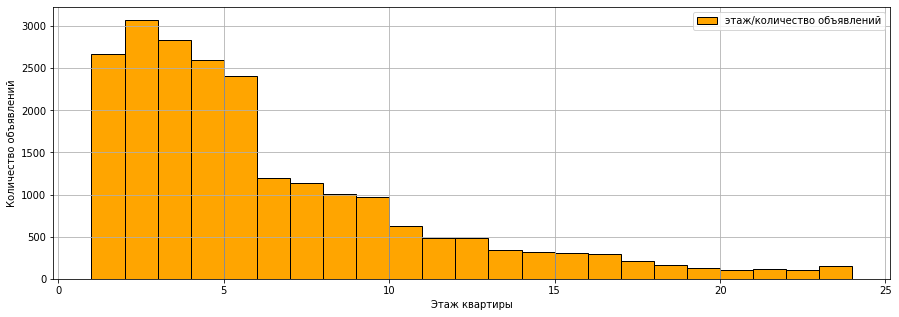

In [30]:
df['floor'].hist(bins=range(1, 25, 1), figsize = (15, 5), color='orange', edgecolor='black', label = 'этаж/количество объявлений')
plt.xlabel('Этаж квартиры')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

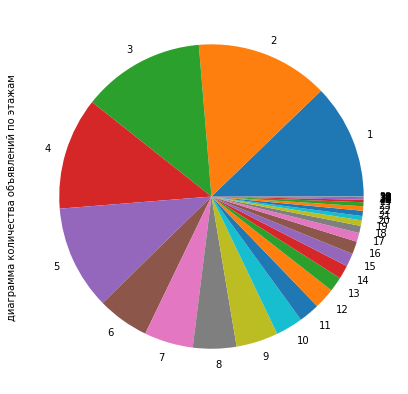

In [31]:
df.groupby('floor')['last_price'].count().plot(kind='pie', figsize = (7,7), label = 'диаграмма количества объявлений по этажам')
plt.show()

Вывод: видно, что чаще всего продают квартиры с 1-5 комнатами. Больше особо добавить нечего по этому столбцу.

##### is_apartment

In [32]:
print('Тип данных:', df['is_apartment'].dtype) # стандартные процедуры
print('Количество пропусков:', df['is_apartment'].isna().sum())
df['is_apartment'].value_counts()

Тип данных: object
Количество пропусков: 19141


False    2613
True       42
Name: is_apartment, dtype: int64

В данных пропусков больше чем заполненных. Возможно, пропуски возникли из-за того, что авторы объявлений не указывали этот параметр при заполнении форм. Столбец не самый важный для исследования. В данном случае, учитывая, что в среднем на рынке квартир сильно больше чем апартаментов, можно поменять все пропуски на False.

In [33]:
df['is_apartment'] = df['is_apartment'].fillna(value=False) # меняем
print('Количество пропусков:', df['is_apartment'].isna().sum()) #проверяем
print('Тип данных:', df.is_apartment.dtype)

Количество пропусков: 0
Тип данных: bool


Вывод: столбец не критичный для исследования. На всякий случай все пропущенные поменяли False.

##### studio

In [34]:
print('Тип данных:', df['studio'].dtype) #стандартные процедуры
print('Количество пропусков:', df['studio'].isna().sum())
df.studio.value_counts()

Тип данных: bool
Количество пропусков: 0


False    21657
True       139
Name: studio, dtype: int64

Вывод: с этим столбцом всё в порядке, трогать не будем.

##### open_plan

In [35]:
print('Тип данных:', df['open_plan'].dtype) #стандартные процедуры
print('Количество пропусков:', df['open_plan'].isna().sum())
df['open_plan'].value_counts()

Тип данных: bool
Количество пропусков: 0


False    21734
True        62
Name: open_plan, dtype: int64

Вывод: с этим столбцом тоже всё в порядке, трогать не будем.

##### kithchen_area

In [36]:
print('Тип данных:', df['kitchen_area'].dtype) #стандартные процедуры
print('Количество пропусков:', df['kitchen_area'].isna().sum())
df['kitchen_area'].describe()

Тип данных: float64
Количество пропусков: 814


count    20982.000000
mean        10.516987
std          5.843371
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Кухня площадью 112 м2. Думаю, что в квартирах с 300 м2 вполне возможно такое. А вот размер 1.3 м2 для кухни всё-таки маловато, скорее на уборную похоже. Построим графики:

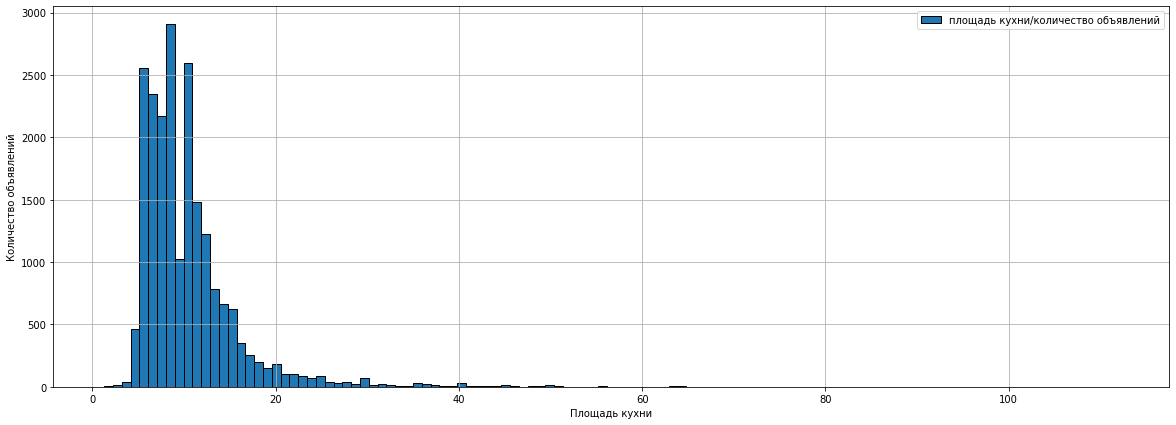

In [37]:
df['kitchen_area'].hist(bins=115, figsize=(20,7), edgecolor='black', label = 'площадь кухни/количество объявлений')
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: Судя по графику, подавляющее число квартир располагают кухней в 5-12 м2.
Обнаружено некоторое количество пропусков. Это подозрительно, так как параметр входит в топ ключевых для определения цены квартиры. Можно было бы предположить, что пропуски данных фигурируют в студиях, или в квартирах с открытой планировкой. Но таких квартир слишком мало. (Студий и с открытой планировкой - всего около 200, а тут пропусков свыше 800).Скорее всего, пропуски возникли по техническим причинам. Заказчика стоит предупредить об этом. Можно было бы заполнить данные мединным значением, но в данном случае это кажется плохой идеей, так как этих значений не много (около 5% от всей выборки), они могут коррелировать с другими параметрами, а мы можем нарушить эту зависимость (к примеру, площадь кухни окажется больше всей квартиры, хотя, конечно, это маловероятно), что также может сказать на других результатах исследования. Думаю, лучше отказаться от этих данных совсем, просто удалив их.

In [38]:
print('Количество строк до удаления пропусков:', df.shape) # смотрим
df = df.dropna(subset=['kitchen_area']) # удаляем
# проверяем
print('Количество записей после удаления пропусков:', df.shape) #
print('Количество пропусков в колонке kitchen_area:', df.kitchen_area.isna().sum())

Количество строк до удаления пропусков: (21796, 22)
Количество записей после удаления пропусков: (20982, 22)
Количество пропусков в колонке kitchen_area: 0


##### balcony

In [39]:
print('Тип данных:', df['balcony'].dtype) # стандартные процедуры
print('Количество пропусков:', df['balcony'].isna().sum())
df['balcony'].describe().to_frame()

Тип данных: float64
Количество пропусков: 9764


,balcony
count,11218.000000
mean,1.156623
std,1.065971
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,5.000000


Тип данных распознан неверно, балконов-половинок не бывает. Также много пропусков, вероятно, собственники квартир без балконов просто оставили это поле пустым. Логично будет заполнить пропуски нулями.

In [40]:
df['balcony'] = df['balcony'].fillna(0) # заполняем пропуски нулями
# контроль
print('Количество пропусков:', df.balcony.isna().sum())

Количество пропусков: 0


In [41]:
df.loc[:,'balcony'] = df.loc[:,'balcony'].astype('int') #меняем тип данных на целочисленный
print('Тип данных:', df['balcony'].dtype) #проверяем

Тип данных: int64


Построим круговой график:

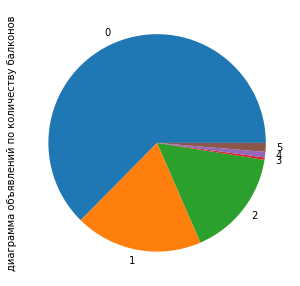

In [42]:
df.groupby('balcony')['last_price'].count().plot(kind='pie', figsize = (5,5), label = 'диаграмма объявлений по количеству балконов')
plt.show()

Вывод: значения в целочисленные перевели, пропуски в данном случае заполнили нулями. Круговая диаграмма показывает, что доля квартир без балконов самая большая, при этом если не брать эту категорию, в основном квартиры имеют 1-2 балкона, что подтверждается на практике. Есть квартиры с 5 балконами, но это, также как и площади в 900 м2 и кухни по 300м2, вероятно, выбросы. Их немного, пока трогать не будем.

##### locality_name

In [43]:
print('Тип данных:', df['locality_name'].dtype) # стандартные процедуры
print('Количество пропусков:', df['locality_name'].isna().sum())
print('Всего различных значений', len(df['locality_name'].unique()))
print(df['locality_name'].unique())  # по заданию, надо удалить дубликаты в названиях, поэтому выведем список уникальных значений.

Тип данных: object
Количество пропусков: 39
Всего различных значений 346
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Колпино' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный'
 'деревня Старая' 'деревня Лесколово' 'село Путилово' 'Ивангород' 'Мурино'
 'Сланцы' 'Шлиссельбург' 'Сясьстрой' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'поселок Новый Свет' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'посе

Обработаем пропуски. Их немного, и можно было бы просто удалить, но мы поступим иначе. Заменим их на что-то нейтральное и часто встречающееся. 

In [45]:
df['locality_name'].value_counts().head()

Санкт-Петербург    14071
посёлок Мурино       402
посёлок Шушары       393
Всеволожск           357
Пушкин               337
Name: locality_name, dtype: int64

Санкт-Петербург наиболее частое значение, да и квартиры продают либо в этом городе, либо в окрестностях. Поменяем пропуски на "Санкт-Петербург":

In [46]:
df['locality_name'] = df['locality_name'].fillna('Санкт-Петербург')
# контроль
print('Количество пропусков:', df.locality_name.isna().sum())

Количество пропусков: 0


Отлично, идём дальше. Начнем обработку дубликатов с того, что поменяем везде "ё" на "е". Многие люди часто не ставят точки над "ё", из за этого в данных могут возникнуть неявные дубликаты.

In [47]:
print('Всего различных значений до', len(df['locality_name'].unique())) # проверим
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=False) # начнем с того, что 
#поменяем везде "ё" на "е". Многие люди часто не ставят точки над "ё".
print('Всего различных значений после', len(df['locality_name'].unique())) # проверим

Всего различных значений до 345
Всего различных значений после 311


Отлично количество уникальных значений упало с 345 до 311, но судя по списку значений, в данных этого столбца явно есть неявные дубликаты ("поселки городского типа", "коттеджные поселки", "городские поселки", а также просто "поселки", вероятно, один и тот же населенный пункт.). Обработаем эти дубликаты, приведем все вышеперечисленные к просто "поселку": 

In [48]:
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('городской поселок', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('поселок городского типа', 'поселок'))
df['locality_name'] = df['locality_name'].apply(lambda x: x.replace('коттеджный поселок', 'поселок'))
print('Всего различных значений после', len(df['locality_name'].unique())) # проверим
print(df['locality_name'].unique())

Всего различных значений после 302
['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Колпино' 'Гатчина' 'деревня Федоровское' 'Выборг'
 'Кронштадт' 'Кировск' 'деревня Новое Девяткино' 'поселок Металлострой'
 'поселок Лебяжье' 'поселок Сиверский' 'поселок Молодцово'
 'поселок Кузьмоловский' 'садовое товарищество Новая Ропша' 'Павловск'
 'деревня Пикколово' 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск'
 'Сестрорецк' 'деревня Куттузи' 'поселок Аннино' 'деревня Заклинье'
 'поселок Торковичи' 'поселок Первомайское' 'Красное Село'
 'поселок Понтонный' 'деревня Старая' 'деревня Лесколово' 'село Путилово'
 'Ивангород' 'Мурино' 'Сланцы' 'Шлиссельбург' 'Сясьстрой' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Свет' 'деревня Оржицы'
 'деревня Кальтино' 'Кудрово' 'поселок Романовка' 'поселок Бугры'
 'поселок Рощино' 'Кириши' 'Луга' 'Волосово' 'Отрадное' 'село Павлово'
 'поселок Оре

Вывод: Хорошо, сократили дубликаты почти на 15%, думаю пока этого достаточно.
По итогу, выявлено незначительное количество пропусков. Возможно жители Питера просто не указывали город. Пропуски заменены наиболее частым значением ("Санкт-Петербург"). Дубликаты в данных обработаны путем замены "ё" на "е", а также путем замены "поселков городского типа", "коттеджных поселков" и "городских поселков" на просто "поселки".

##### airports_nearest

In [49]:
print('Тип данных:', df['airports_nearest'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['airports_nearest'].isna().sum())
df['airports_nearest'].describe()


Тип данных: float64
Количество пропусков: 4674


count    16308.000000
mean     28773.990925
std      12642.885702
min          0.000000
25%      18539.000000
50%      26679.000000
75%      37199.000000
max      84869.000000
Name: airports_nearest, dtype: float64

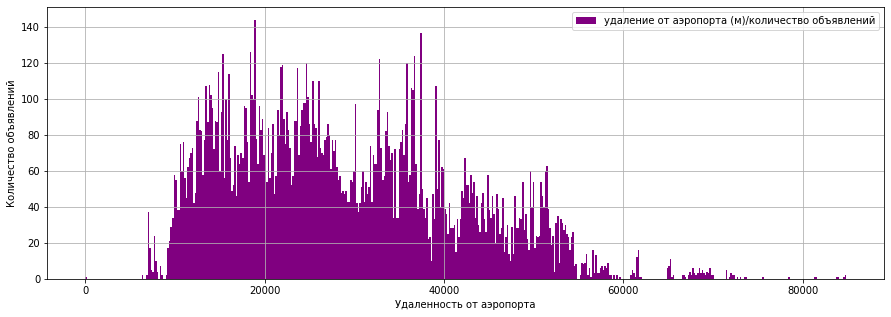

In [50]:
df['airports_nearest'].hist(bins = 500, color = 'purple', figsize = (15, 5), label = 'удаление от аэропорта (м)/количество объявлений')
plt.xlabel('Удаленность от аэропорта')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: Пропусков не мало, и есть странное значение - 0. Квартира в аэропорту?. Вряд ли. Колонка заполнялась автоматически, имеет место явная техническая ошибка, заполнять каким-либо значением, думаю не стоит, лучше сообщить специалистам, которые выгружают данные. В остальном данные в порядке.


##### cityCenters_nearest

In [51]:
print('Тип данных:', df.cityCenters_nearest.dtype) # Стандартные процедуры
print('Количество пропусков:', df['cityCenters_nearest'].isna().sum())
df['cityCenters_nearest'].describe()

Тип данных: float64
Количество пропусков: 4653


count    16329.000000
mean     14236.307551
std       8662.711834
min        181.000000
25%       9324.000000
50%      13107.000000
75%      16267.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [52]:
df = df.rename({'cityCenters_nearest': 'city_center_nearest'}, axis=1) #переведем на змеиный регистр
# проверим
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_center_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

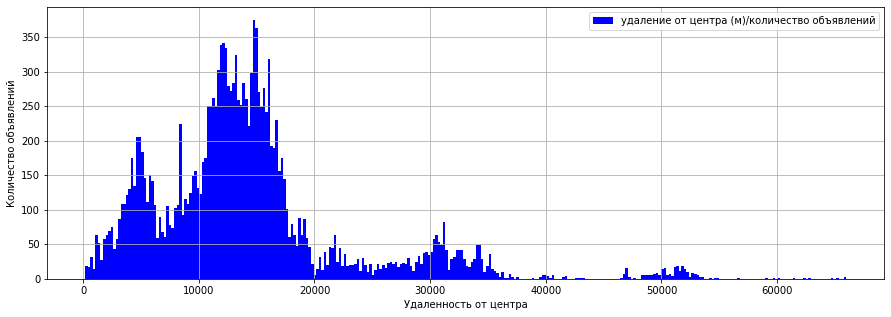

In [53]:
df['city_center_nearest'].hist(bins = 300, color = 'blue', figsize = (15, 5), label = 'удаление от центра (м)/количество объявлений')
plt.xlabel('Удаленность от центра')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: Обнаружены аналогичные проблемы, как со столбцом airports_nearest. Требуются аналогичные действия для решения технической проблемы. Колонка была переименована для соответствия правилам змеиного регистра.

##### parks_around3000

In [54]:
print('Тип данных:', df['parks_around3000'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['parks_around3000'].isna().sum())
df['parks_around3000'].describe().to_frame()

Тип данных: float64
Количество пропусков: 4652


,parks_around3000
count,16330.000000
mean,0.611451
std,0.801266
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3.000000


Переведем количество парков рядом в целочисленное значение. Рядом с жильём не может быть 1,8 парка.

In [55]:
df['parks_around3000'] = df['parks_around3000'].astype('Int64', errors='ignore') #
# контроль
print('Тип данных:', df.parks_around3000.dtype)

Тип данных: Int64


Вывод: Пропуски, несмотря на то что их немало, придется оставить как есть. Данный столбец, вероятно, также заполняется автоматически, поэтому помимо всего прочего, тем кто выгружает данные нужно будет заняться данной проблемой тоже. Столбец переведен в целочисленный тип данных.

##### parks_nearest

In [56]:
print('Тип данных:', df['parks_nearest'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['parks_nearest'].isna().sum())
df['parks_nearest'].describe()

Тип данных: float64
Количество пропусков: 13716


count    7266.000000
mean      487.838701
std       337.388649
min         1.000000
25%       287.250000
50%       453.500000
75%       610.750000
max      3190.000000
Name: parks_nearest, dtype: float64

Вывод: тип данных определен верно, но пропусков более половины. Аналогично предыдущему, техническая ошибка, нужно сообщить о проблеме. Заполнять каким-либо средним или медианой будет некорректно.

##### ponds_around3000

In [57]:
print('Тип данных:', df['ponds_around3000'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['ponds_around3000'].isna().sum())
df['ponds_around3000'].describe()

Тип данных: float64
Количество пропусков: 4652


count    16330.000000
mean         0.763748
std          0.937921
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

Вывод: Пропусков немало, но их снова придется оставить как есть, и пополнить список проблем для тех кто выгружает данные. Снова техническая ошибка. Единственное, аналогично parks_around3000 переведём в целочисленный формат. 

In [58]:
df['ponds_around3000'] = df['ponds_around3000'].astype('Int64', errors='ignore')
# проверим
print('Тип данных:', df.ponds_around3000.dtype)

Тип данных: Int64


##### ponds_nearest

In [59]:
print('Тип данных:', df['ponds_nearest'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['ponds_nearest'].isna().sum())
df['ponds_nearest'].describe()

Тип данных: float64
Количество пропусков: 12882


count    8100.000000
mean      519.422963
std       277.396212
min        13.000000
25%       295.000000
50%       503.000000
75%       732.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

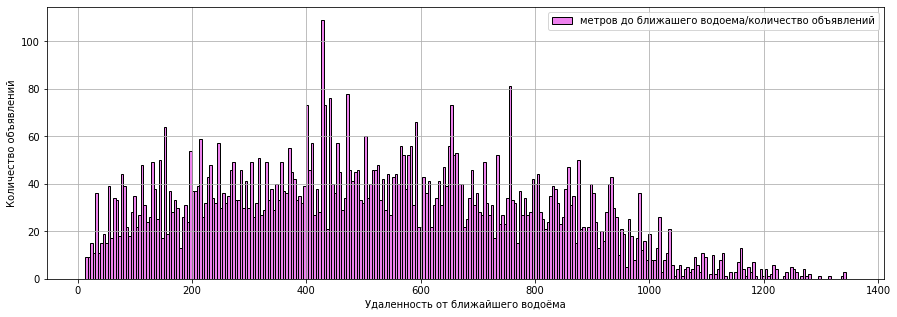

In [60]:
df['ponds_nearest'].hist(bins = 300, figsize = (15,5), edgecolor='black', color = 'violet', label = 'метров до ближашего водоема/количество объявлений')
plt.xlabel('Удаленность от ближайшего водоёма')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: в данном случае у нас больше половины пропусков данных. Следует сообщить о проблеме всё тем же людям, а столбец пока оставить как есть.

##### days_exposition

In [61]:
print('Тип данных:', df['days_exposition'].dtype) # Стандартные процедуры
print('Количество пропусков:', df['days_exposition'].isna().sum())
df['days_exposition'].describe()

Тип данных: float64
Количество пропусков: 2891


count    18091.000000
mean       185.665137
std        221.968080
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

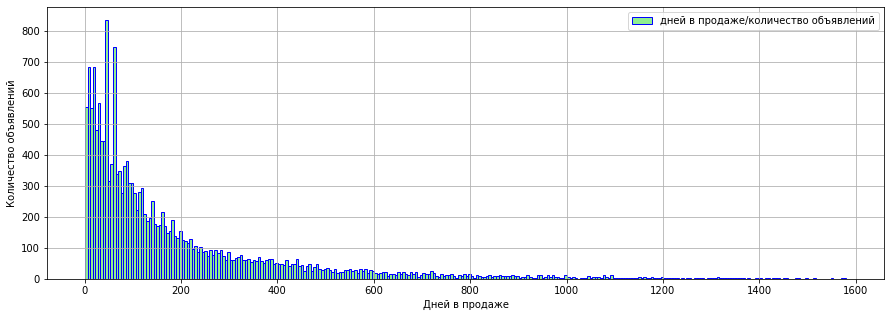

In [62]:
df['days_exposition'].hist(bins = 300, figsize = (15, 5), color='lightgreen', edgecolor = 'blue', label = 'дней в продаже/количество объявлений')
plt.xlabel('Дней в продаже')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: В данном случае обнаружено почти 3000 пропусков данных. Так как данная колонка скорее всего также как и несколько предыдущих заполнялась автоматически, то причиной пропусков могла стать, вероятнее всего, техническая ошибка, о чём следует сообщить специалистам по выгрузке данных.

##### Итог по предобработке

В результате предобработки выявлено несколько столбцов с пропусками в данных. В некоторых случаях пропуски были заменены на подходящие значения (медианы). В некоторых случаях пропуски были оставлены, так как скорее всего возникли по техническим причинам и их замена привела бы к искажению результатов исследования. Также данные в некоторых колонках были удалены, так как их использование могло бы также исказить результаты. Явных дупликатов в данных не обнаружено, неявные насколько возможно обработаны. Также частично обработаны аномальные значения.

### Добавьте в таблицу новые столбцы

#### Цена за квадрат

In [63]:
df['sq_meter_cost'] = (df['last_price'] / df['total_area']).round(2) #дополняем
# проверяем
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,поселок Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55.0,95065.79


#### День недели, месяц, год публикации

In [64]:
df['weekday'] = df['first_day_exposition'].dt.day_of_week #день недели
df['month'] = df['first_day_exposition'].dt.month # месяц
df['year'] = df['first_day_exposition'].dt.year #год
df.head() #проверяем

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,<NA>,NaN,<NA>,NaN,55.0,95065.79,0,9,2018


#### Категория этажа квартиры

In [65]:
def floor_categories(row): #напишем функцию категоризации
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_category'] = df.apply(floor_categories, axis=1) #применим к столбцу

In [66]:
print(df['floor_category'].value_counts()) #проверим
df.head()

другой       15404
последний     3018
первый        2560
Name: floor_category, dtype: int64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,weekday,month,year,floor_category
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,<NA>,NaN,<NA>,NaN,55.0,95065.79,0,9,2018,другой


#### Расстояние до центра в километрах

In [67]:
df['city_center_nearest_km'] = (df['city_center_nearest'] / 1000).round(0) # создаем столбец
df['city_center_nearest_km'] = df['city_center_nearest_km'].astype('Int64', errors='ignore')
pd.set_option('display.max_columns', None)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,weekday,month,year,floor_category,city_center_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,поселок Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55.0,95065.79,0,9,2018,другой,<NA>


### Проведите исследовательский анализ данных

#### Общая площадь

In [68]:
df['total_area'].describe()

count    20982.000000
mean        60.547304
std         34.497775
min         14.000000
25%         40.500000
50%         52.205000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

Смущает максимальное значение. Построим гистограмму и boxplot.

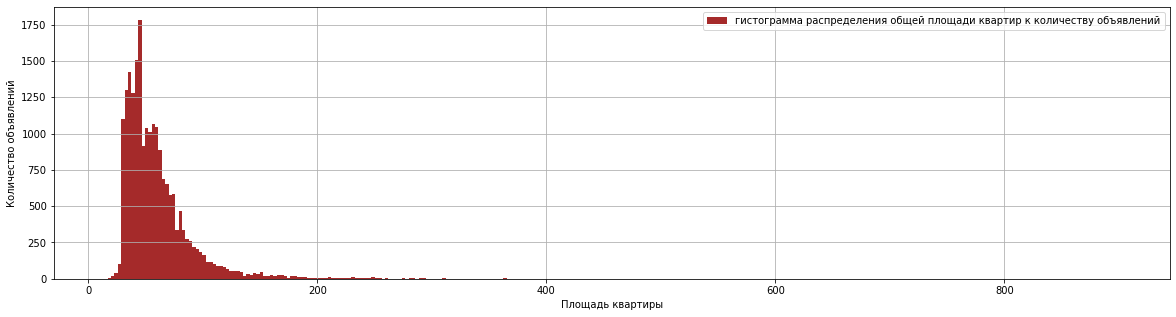

In [69]:
df['total_area'].hist(bins = 300, figsize=(20, 5), color = 'brown', label = 'гистограмма распределения общей площади квартир к количеству объявлений')
plt.xlabel('Площадь квартиры')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

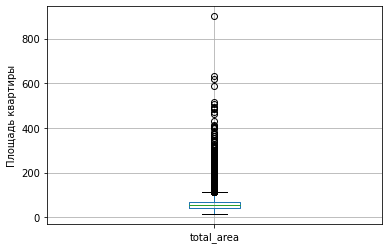

In [70]:
df.boxplot(column=['total_area'])
plt.ylabel('Площадь квартиры')
plt.show()

Выведем строку с выбросом:

In [71]:
print(df.loc[df['total_area'] == 900])

       total_images   last_price  total_area first_day_exposition  rooms  \
19540             8  420000000.0       900.0           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
19540             2.8            25        409.7     25         False   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
19540      False         112.0        0  Санкт-Петербург           30706.0   

       city_center_nearest  parks_around3000  parks_nearest  ponds_around3000  \
19540               7877.0                 0            NaN                 2   

       ponds_nearest  days_exposition  sq_meter_cost  weekday  month  year  \
19540          318.0            106.0      466666.67        2     12  2017   

      floor_category  city_center_nearest_km  
19540      последний                       8  


Изначально можно было предположить, что в столбце total_area или во всех в данной строчке просто лишний ноль. Но нет, комнат 12, а их не может быть дробное число, значит квартира, вероятно, настоящая.


Построим гистограмму без выбивающихся значений:

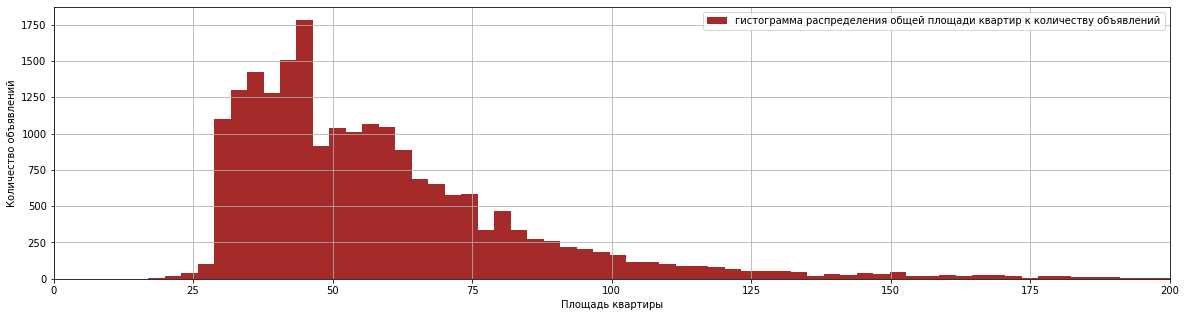

In [72]:
df['total_area'].hist(bins = 300, figsize=(20, 5), color = 'brown', label = 'гистограмма распределения общей площади квартир к количеству объявлений')
plt.xlim(0, 200)
plt.xlabel('Площадь квартиры')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: средний диапазон общей площади квартир на рынке - 30-75 м2. Оно и понятно, в меньших квартирах жить трудно, в больших - надо сильно постараться.

#### Жилая площадь

In [73]:
df['living_area'].describe()

count    20982.000000
mean        34.644380
std         21.916891
min          2.000000
25%         18.800000
50%         30.100000
75%         42.547500
max        409.700000
Name: living_area, dtype: float64

В той строке, с квартирой в 900 м2, как раз можно заметить, что она и имеет жилую площадь 409,7 м2. Эта квартира и здесь делает максимум значения.

 Построим boxplot и гистограмму без выбивающихся значений: 

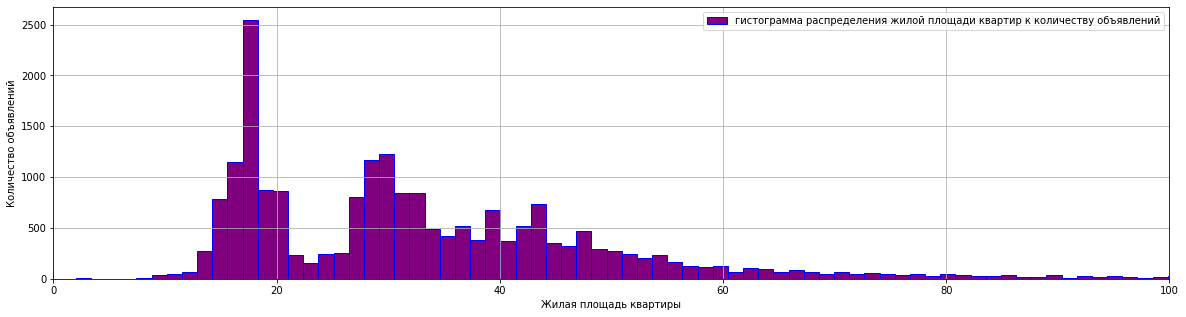

In [74]:
df['living_area'].hist(bins = 300, figsize=(20, 5), color = 'purple', edgecolor='blue', label = 'гистограмма распределения жилой площади квартир к количеству объявлений')
plt.xlim(0, 100)
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

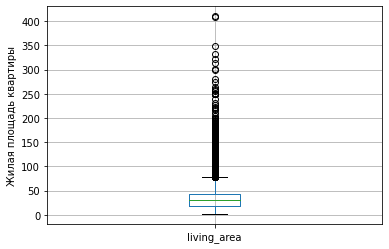

In [75]:
df.boxplot(column=['living_area'])
plt.ylabel('Жилая площадь квартиры')
plt.show()

Вывод: Средний диапазон жилой площади квартир на рынке находится в пределах 12-40 м2. 

#### Площадь кухни

In [76]:
df['kitchen_area'].describe()

count    20982.000000
mean        10.516987
std          5.843371
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

И снова квартира с 900 м2. 3 номинация за ней - самая большая кухня. Построим гистограмму без выбивающихся значений:

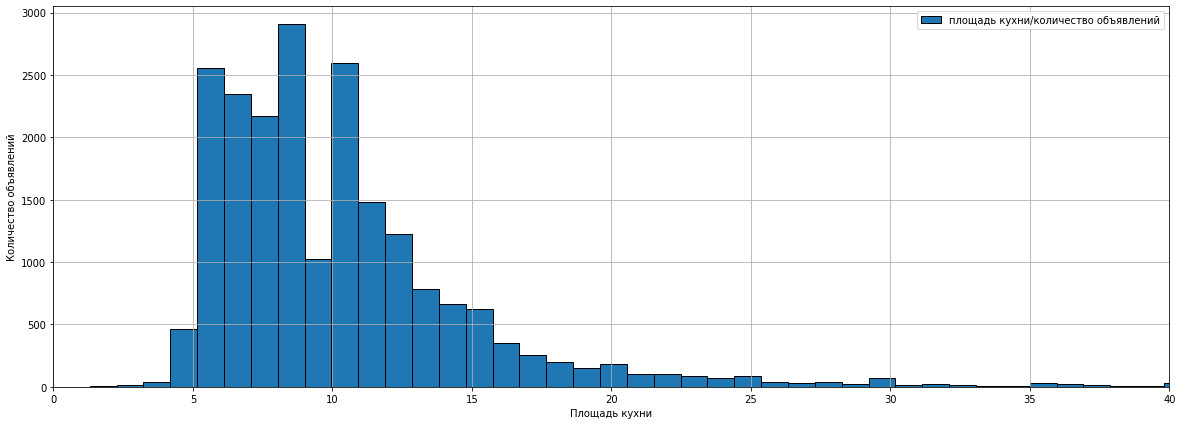

In [77]:
df['kitchen_area'].hist(bins=115, figsize=(20,7), edgecolor='black', label = 'площадь кухни/количество объявлений')
plt.xlim(0, 40)
plt.xlabel('Площадь кухни')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: средний диапазон площади кухни у квартир на рынке находится в пределах 5-20 м2.

#### Цена

In [78]:
df['last_price'].describe()

count    2.098200e+04
mean     6.506827e+06
std      9.592656e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      4.200000e+08
Name: last_price, dtype: float64

Построим гистограмму без выбивающихся значений:

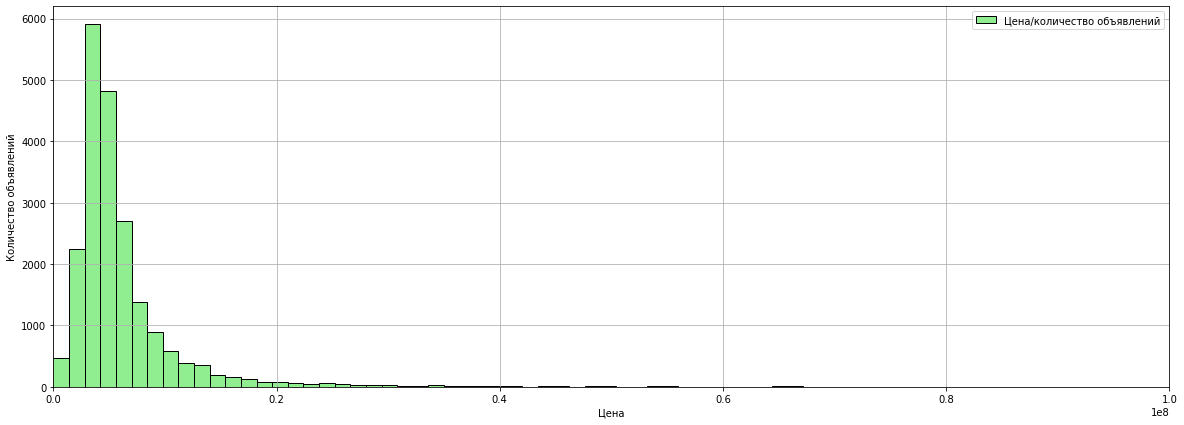

In [79]:
df['last_price'].hist(bins=300, figsize=(20,7), color = 'lightgreen', edgecolor = 'black', label = 'Цена/количество объявлений')
plt.xlim(0, 100000000)
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: в столбце с ценой большое количество выбросов. Средний диапазон цены колеблется в районе 3-10 миллионов.

#### Комнаты

In [80]:
df['rooms'].describe()

count    20982.000000
mean         2.096035
std          1.064559
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

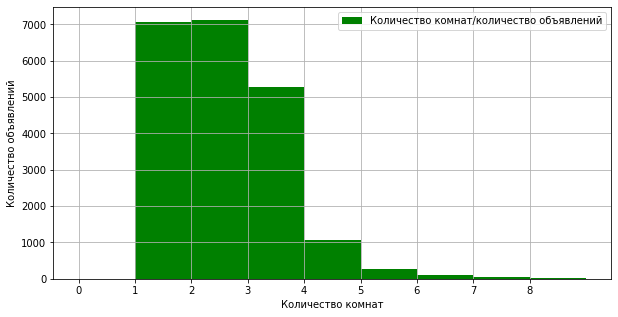

In [81]:
df['rooms'].hist(bins=range(0, 10, 1), figsize=(10,5), color='green', label='Количество комнат/количество объявлений')
plt.xticks(range(0, 9))
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: Большинство квартир имеет от 1 до 5 комнат, есть несколько квартир с большим (до 19) количеством комнат. Но это не та, что с площадью 900м2, в той всего 12. Возможно, эти записи - ошибки. Представить себе квартиру с 19 комнатами трудно, хотя, конечно, всё возможно.

#### Высота потолков

In [82]:
print(df['ceiling_height'].describe())

count    20982.00000
mean         2.72315
std          0.99492
min          1.00000
25%          2.60000
50%          2.65000
75%          2.70000
max        100.00000
Name: ceiling_height, dtype: float64


Построим boxplot():

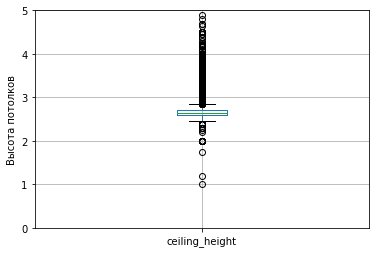

In [83]:
df.boxplot(column=['ceiling_height'])
plt.ylabel('Высота потолков')
plt.ylim(0, 5)
plt.show()

Много выбросов, построим гистограмму:

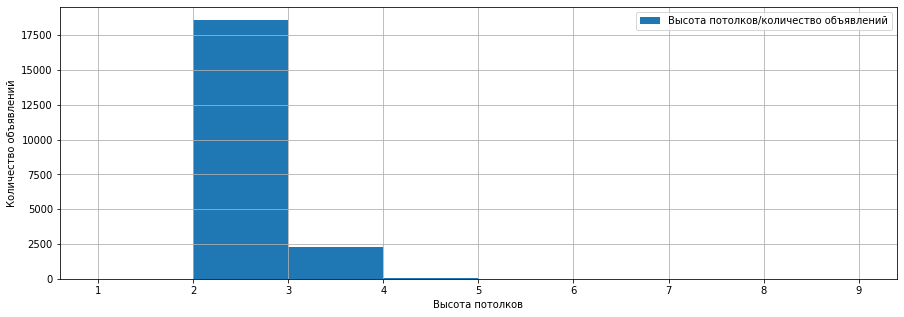

In [84]:
df['ceiling_height'].hist(bins=range(1,10,1), figsize=(15,5), label='Высота потолков/количество объявлений')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Как и ожидалось потолки высотой 2-3 м - самые распространённые.
Метод describe и boxplot показал, что много аномальных значений. Странные потолки высотой 1м (min) и 100м(max)... и не только эти. Вообще, потолки в квартирах менее 2,2 м и более 10 м (даже 5) выглядят нереальными. Посмотрим много ли потолков выше 10 м:


In [85]:
print(df.loc[df['ceiling_height'] >= 10]) #Посмотрим много ли значений потолков выше 10 м

       total_images  last_price  total_area first_day_exposition  rooms  \
3148             14   2900000.0        75.0           2018-11-12      3   
4643              0   4300000.0        45.0           2018-02-01      2   
5076              0   3850000.0        30.5           2018-10-03      1   
5246              0   2500000.0        54.0           2017-10-13      2   
5669              4   4400000.0        50.0           2017-08-08      2   
5807             17   8150000.0        80.0           2019-01-09      2   
6246              6   3300000.0        44.4           2019-03-25      2   
9379              5   3950000.0        42.0           2017-03-26      3   
10773             8   3800000.0        58.0           2017-10-13      2   
11285             0   1950000.0        37.0           2019-03-20      1   
14382             9   1700000.0        35.0           2015-12-04      1   
15061            19   5600000.0        56.4           2018-05-11      2   
17496            15   670

Так, значений немного, но они есть. Логично заподозрить ошибку при выгрузке данных. Значения потолков 32 м выроятнее всего имеют высотку 3,2 м. Исправим этот недочет:

In [86]:
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df['ceiling_height'] / 10


In [87]:
print('Количество квартир с потолками выше 10м', len(df.loc[df['ceiling_height'] > 10])) #проверяем

Количество квартир с потолками выше 10м 0


Вывод: Отлично, поправили.
Аномальные значения мы обработали, пропуски на этапе предобработки заполнили.
Средний диапазон высоты потолков состаляет 2-3 м, медианное значение 2,65. Идем дальше.

#### Тип этажа квартиры («первый», «последний», «другой»)

floor_category
другой       15404
первый        2560
последний     3018
Name: floor_category, dtype: int64


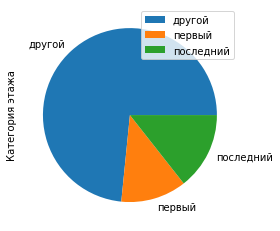

In [88]:
print(df.groupby('floor_category')['floor_category'].count()) # Посмотрим на числовое распределение категорий этажей
df.groupby('floor_category')['floor_category'].count().plot(kind = 'pie', label = 'Распределение квартир по категориям этажей') #Построим круговой график, мне кажется, 
#в данном случае он будет информативнее гистограммы.
plt.ylabel('Категория этажа')
plt.legend()
plt.show()


Вывод: как ожидаемо можно заметить, самая многочисленная категория - "другой" - ~75% от общего числа объявлений, что само собой разумеется, - в нее входит больше всего вариантов. Тем не менее, учитывая, то что в категорию "первый" и "последний" входит небольшое количество значений, они тоже достаточно многочисленны по ~10-15% каждая. Идем дальше.

#### Общее количество этажей в доме

count    20982.000000
mean        10.564055
std          6.519155
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64


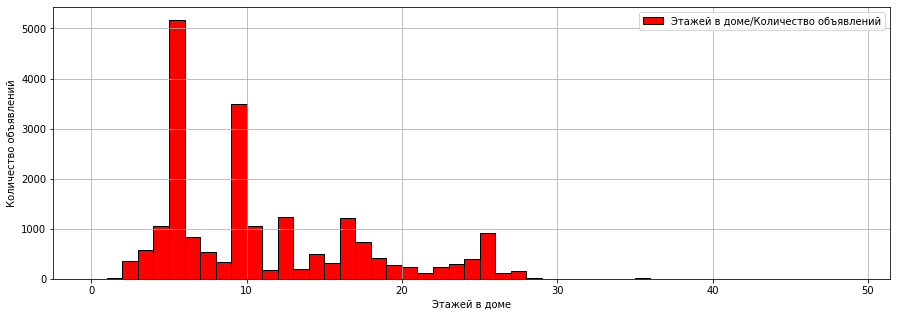

In [89]:
print(df['floors_total'].describe()) #еще раз посмотрим на распределение значений и 
# построим гистограмму:
df['floors_total'].hist(bins=range(0, 50, 1), figsize=(15,5), color='red', edgecolor='black', label='Этажей в доме/Количество объявлений')
plt.xlabel('Этажей в доме')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: по гистограмме видно, что чаще всего продают квартиры, которые находятся в диапазоне 5-10 этажей. Оно и понятно, на данный момент, это самая многочисленная категория, так как жилой фонд пока еще недостаточно многоэтажный, хотя конечно все это со временем меняется. Основные советские постройки имеют этажность 5-14 этажей.
На этапе предобработки, мы обнаружили что были объявления в которых этаж квартиры был выше, чем всего этажей в доме, что скорее всего (ввиду из немногочисленности всего 37 таких записей) является ошибкой из-за человеческого фактора. В этом случае, мы поменяли данные местами "этаж квартиры" <==> "всего этажей". Идем дальше.

#### расстояние до центра города в метрах

In [90]:
print(df['city_center_nearest'].describe())  #еще раз посмотрим на распределение значений, но сейчас посомтрим на колонку,
# которая измеряется в км и  построим гистограмму:

count    16329.000000
mean     14236.307551
std       8662.711834
min        181.000000
25%       9324.000000
50%      13107.000000
75%      16267.000000
max      65968.000000
Name: city_center_nearest, dtype: float64


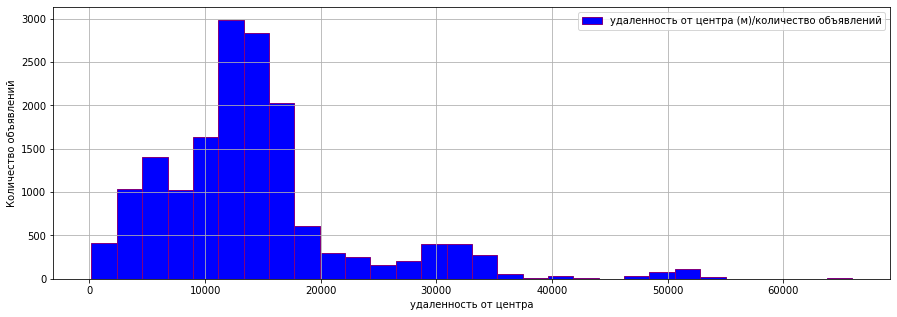

In [91]:
df['city_center_nearest'].hist(bins = 30, color = 'blue', edgecolor='purple', figsize = (15, 5), label = 'удаленность от центра (м)/количество объявлений')
plt.xlabel('удаленность от центра')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: в основном, продают квартиры, которые находятся в 5-18 км от центра города. Думаю, это можно объяснить тем, что плотность застройки в городе сильно выше чем за его пределами.

#### Расстояние до ближайшего парка

count    7266.000000
mean      487.838701
std       337.388649
min         1.000000
25%       287.250000
50%       453.500000
75%       610.750000
max      3190.000000
Name: parks_nearest, dtype: float64


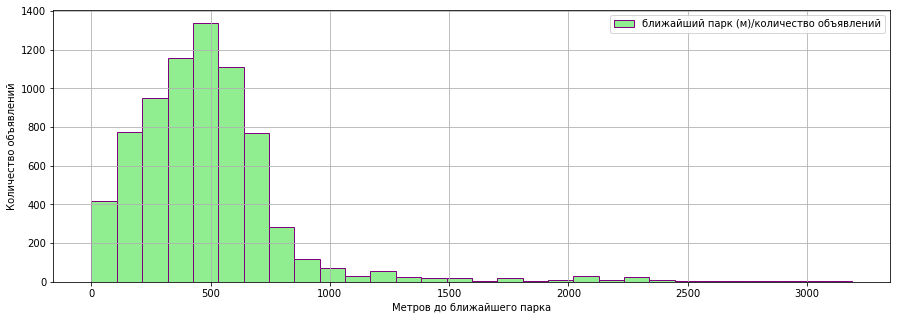

In [92]:
print(df['parks_nearest'].describe()) # еще раз посмотрим на распределение значений и построим гистограмму:
df['parks_nearest'].hist(bins = 30, color = 'lightgreen', edgecolor='purple', figsize = (15, 5), label = 'ближайший парк (м)/количество объявлений')
plt.xlabel('Метров до ближайшего парка')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: видно, что большинство продаваемых квартир находятся в 100-700 м от парка. Неплохой показатель, зеленые насаждения нужны человеку для поддержания здоровья.

#### Как быстро продавались квартиры

count    18091.000000
mean       185.665137
std        221.968080
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64


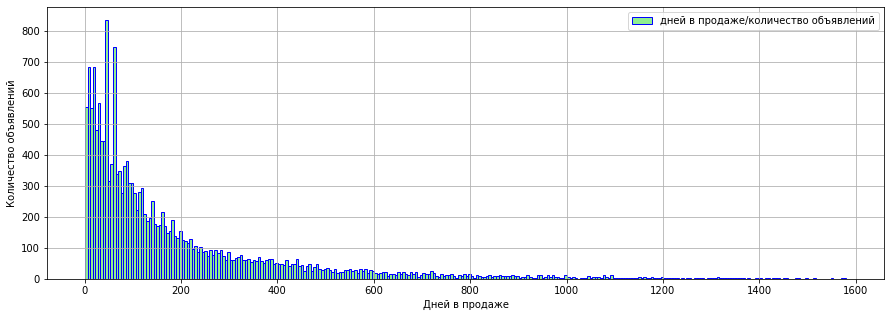

In [93]:
print(df['days_exposition'].describe())
df['days_exposition'].hist(bins = 300, figsize = (15, 5), color='lightgreen', edgecolor = 'blue', label = 'дней в продаже/количество объявлений')
plt.xlabel('Дней в продаже')
plt.ylabel('Количество объявлений')
plt.legend()
plt.show()

Вывод: чаще всего квартиры продаются в течение 1-3 месяцев, что исходя из жизненного опыта, является истиной. Медиана в данном случае составляет ~100 дней, среднее 185 дней. Разница между ними достаточная, что, вероятно, связано с отдельно взятыми объектами продажи: ликвидными и не очень.
Продажу судя по гистограмме менее чем пару недель можно считать быстрой, более года - необычайно долгой.

#### Посчитаем количество "очищенных" данных к количеству "грязных"

In [94]:
print(df.shape) #Посмотрим количество строк после фильтрации данных
stroke_filtered = df.shape[0] #запишем в переменную
print(stroke_filtered) #проверим

(20982, 28)
20982


In [95]:
print('Всего строк удалено:', stroke_total - stroke_filtered, 'из', stroke_total) 
print('Количество данных, которое осталось после фильтрации', round((stroke_filtered/stroke_total*100), 0), '%')

Всего строк удалено: 2717 из 23699
Количество данных, которое осталось после фильтрации 89.0 %


Вывод: количество данных оставшихся после фильтрации составляет 89% от изначальной выборки, что позволяет нам назвать наше проведенное исследование актуальным.

#### Вывод по исследовательскому анализу данных.

После всех фильтраций количество данных которое удалось сохранить составляет 89%, что близко к необходимому для актуального анализу количеству.
После проведенного анализа можно сказать следующее:
    - Средняя общая площадь продаваемых квартир колеблется в диапазоне 30-75 м2 (52 м2 - медианное значение);
    - При этом жилая находится в диапазоне 12-40 (30 м2 - медианное значение);
    - Площадь кухни в среднем составляет от 3-10 м2 (5м2 - медианное значение);
    - Больше всего продают двушек, следом идут однушки и трёшки;
    - Высота потолков, ожидаемо колеблется в районе 2-3 м, с медианным значением 2,65 м;
    - Больше всего продают средних этажей, но категории "первый" и "последний" состаляют по отдельности значительную часть выборки - по 10- 15% каждая, что может говорить о том, что хозяевам не нравится жить в квартирах данных категорий и они стремятся избавится от них;
    - расстояние до центра в в выборке колеблется в пределах 5-18 км, с медианным значением в 13 км;
    - расстояние до парка в среднем составляет ~500 м;
    - в среднем квартиры продаются за 1-3 месяца.
Итак, если составить портрет типичного объявления, то это будет 2 комнатная квартира, 52 м2, высотой потолков 2,7 м, на 5 этаже в спальном районе, не слишком далеко от центра с парком в шаговой дсотупности.


Помимо составления общей картины объявлений, на данном этапе мы продолжили предобработку данных и избавились от потолков в 25-35 м, заменив их более скромными значениями (поделили их на 10 и получили адекватные - 2,5 - 3,5 м).
    

### Исследование факторов, влияющих на цену

Посмотрим на корреляцию цен и площадей (общая, жилая, кухни и количеством комнат)

In [96]:
print('Коэффициент корреляции между ценой и общей площадью:', 
      df['last_price'].corr(df['total_area']))
print('Коэффициент корреляции между ценой и жилой площадью:', 
      df['last_price'].corr(df['living_area']))
print('Коэффициент корреляции между ценой и площадью кухни:', 
      df['last_price'].corr(df['kitchen_area']))
print('Коэффициент корреляции между ценой и количеством комнат:', 
      df['last_price'].corr(df['rooms']))

Коэффициент корреляции между ценой и общей площадью: 0.6913304350738488
Коэффициент корреляции между ценой и жилой площадью: 0.6032415583426365
Коэффициент корреляции между ценой и площадью кухни: 0.5175401454654457
Коэффициент корреляции между ценой и количеством комнат: 0.3910126139195833


Вывод: цена сильно зависит от общей и жилой площади объекта продажи. Также есть слабая зависимость между ценой и площадью кухни, ценой и количеством комнат.


Построим графики зависимости:

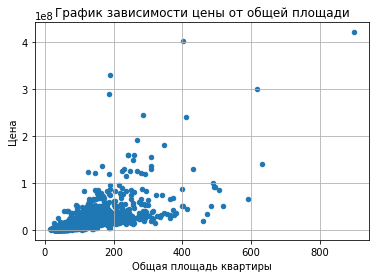

In [97]:
df.plot(x = 'total_area', y = 'last_price', grid = True, kind = 'scatter') # график зависимости цены от общей площади
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена')
plt.title('График зависимости цены от общей площади')
plt.show()

Вывод: график подтверждает наличие зависимости.

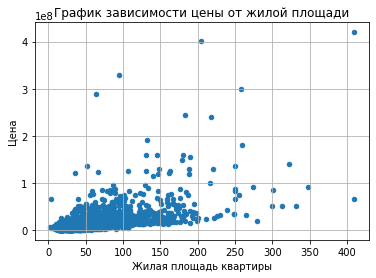

In [98]:
df.plot(x = 'living_area', y = 'last_price', grid = True, kind = 'scatter') # график зависимости цены от жилой площади
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Цена')
plt.title('График зависимости цены от жилой площади')
plt.show()

Вывод: график подтверждает наличие зависимости.

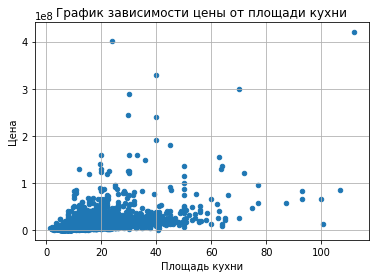

In [99]:
df.plot(x = 'kitchen_area', y = 'last_price', grid = True, kind = 'scatter') # график зависимости цены от площади кухни
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('График зависимости цены от площади кухни')
plt.show()

Вывод:график подтверждает наличие зависимости.

In [100]:
rooms_mean_df = df.groupby('rooms')['last_price'].median() #немного подготовим данные для построения графика,
# построим сводную таблицу медианной цены в зависимости от количества комнат.
rooms_mean_df.reset_index()
rooms_mean_df = rooms_mean_df[:5] # оставим только квартиры с 1-5 комнатами, это самые распространнёные квартиры
rooms_mean_df.columns = ['rooms', 'price']
print(rooms_mean_df)


rooms
1     3600000.0
2     4790000.0
3     6200000.0
4     9000000.0
5    14000000.0
Name: last_price, dtype: float64


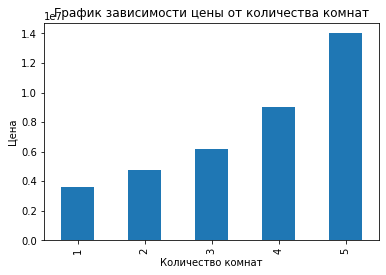

In [101]:
rooms_mean_df.plot(x = 'rooms', y = 'price', kind = 'bar') # график зависимости цены от количества комнат
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('График зависимости цены от количества комнат')
plt.show()

Вывод: да, несмотря на то, что функция выявила не очень сильную корреляцию, график показал её. Больше комнат - обычно больше площадь, а больше площадь, соответственно больше и цена.

In [102]:
fl_cat = df.groupby('floor_category')['last_price'].median()
fl_cat.reset_index(drop = True)
fl_cat.columns = ['floor_category','price']
print(fl_cat)

floor_category
другой       4900000.0
первый       3950000.0
последний    4350000.0
Name: last_price, dtype: float64


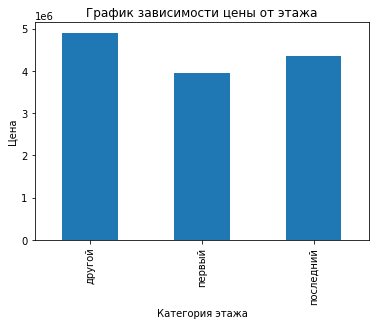

In [103]:
fl_cat.plot(x = 'floor_category', y = 'price', kind = 'bar') # график зависимости цены от количества комнат
plt.xlabel('Категория этажа')
plt.ylabel('Цена')
plt.title('График зависимости цены от этажа')
plt.show()

Вывод: цена продажи зависит от этажа квартиры. Медианные значения цены продажи квартир, расположенных на первом и последнем этажах, ниже, чем медианное значение цены квартир, расположенных на других этажах, график это подтвердил. Все как в жизни, первые и последние этажи могут продавать с дисконтом до 20%.

In [104]:
weekdayprice = df.groupby('weekday')['last_price'].median()
weekdayprice.reset_index(drop = True)
weekdayprice.columns = ['weekday','price']
print(weekdayprice)

weekday
0    4700000.0
1    4777007.0
2    4750000.0
3    4700000.0
4    4600000.0
5    4600000.0
6    4600000.0
Name: last_price, dtype: float64


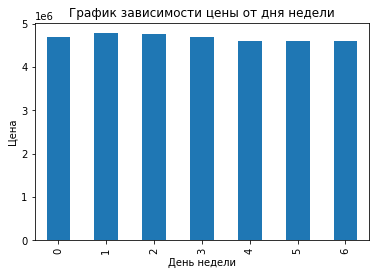

In [105]:
weekdayprice.plot(x = 'weekday', y = 'price', kind = 'bar') # график зависимости цены от количества комнат
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.title('График зависимости цены от дня недели')
plt.show()

Вывод: Медианные значения практически одинаковы. От дня недели размещения объявлений цена практически не зависит.

In [106]:
monthprice = df.groupby('month')['last_price'].median()
monthprice.reset_index(drop = True)
monthprice.columns = ['month','price']
print(monthprice)

month
1     4650000.0
2     4700000.0
3     4700000.0
4     4800227.0
5     4590000.0
6     4494500.0
7     4650000.0
8     4600000.0
9     4735000.0
10    4599000.0
11    4700000.0
12    4850000.0
Name: last_price, dtype: float64


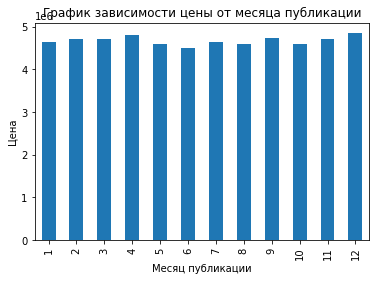

In [107]:
monthprice.plot(x = 'month', y = 'price', kind = 'bar') # график зависимости цены от количества комнат
plt.xlabel('Месяц публикации')
plt.ylabel('Цена')
plt.title('График зависимости цены от месяца публикации')
plt.show()

Вывод: Медианные значения слабо меняются. Летом цена немного падает, наверное, из-за того, что большинство людей находится в отпусках, соотвественно спрос падает. При этом к концу года цена немного растет, что скорее всего связано с инфляцией и ростом цен на жилье.

In [108]:
yearprice = df.groupby('year')['last_price'].median()
yearprice.reset_index(drop = True)
yearprice.columns = ['year','price']
print(yearprice)

year
2014    7640000.0
2015    5265000.0
2016    4550000.0
2017    4550000.0
2018    4650000.0
2019    5089500.0
Name: last_price, dtype: float64


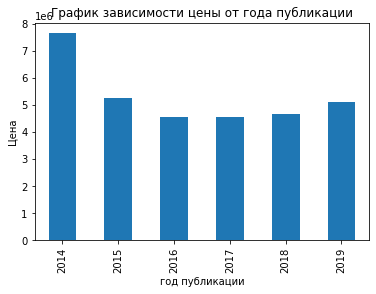

In [109]:
yearprice.plot(x = 'year', y = 'price', kind = 'bar') # график зависимости цены от количества комнат
plt.xlabel('год публикации')
plt.ylabel('Цена')
plt.title('График зависимости цены от года публикации')
plt.show()

Вывод: да, цена зависит от года размещения объявления. Это скорее всего можно объяснить событиями происходями во внутренней и внешней политике.

***Общий вывод: из всех исследуемых параметров на цену квартиры влияют общая и жилая площадь (чем больше, тем дороже), этаж (средние этажи стоят дороже, чем первый и последний) и немного влияют месяц (почти несущественно) и год публикации, который по факту является отражением экономической ситуации на рынке.

### Средняя цена квадратного метра в зависимости от населённого пункта

In [110]:
# группируем по населённому пункту
locality_mean_price = df.groupby('locality_name').agg({'sq_meter_cost': ['count', 'mean']})
# меняем название колонок на более информативные
locality_mean_price.columns = ['qty_of_ads', 'mean_sq_meter_price']
# сортируем
locality_mean_price = locality_mean_price.sort_values(by='qty_of_ads', ascending=False).round(0)
print('Десять населённых пунктов с самым большим количеством объявлений и средняя цена квадратного метра:')
locality_mean_price['mean_sq_meter_price'].head(10)

Десять населённых пунктов с самым большим количеством объявлений и средняя цена квадратного метра:


locality_name
Санкт-Петербург      113847.0
поселок Мурино        85367.0
поселок Шушары        78535.0
Всеволожск            69029.0
Пушкин               103291.0
Колпино               75226.0
Гатчина               68636.0
поселок Парголово     90756.0
деревня Кудрово       92248.0
Выборг                58319.0
Name: mean_sq_meter_price, dtype: float64

In [111]:
print('Населённый пункт с самой высокой средней стоимостью квадратного метра:',
     locality_mean_price['mean_sq_meter_price'].head(10).idxmax())
print('Населённый пункт с самой низкой средней стоимостью квадратного метра:',
     locality_mean_price['mean_sq_meter_price'].head(10).idxmin())

Населённый пункт с самой высокой средней стоимостью квадратного метра: Санкт-Петербург
Населённый пункт с самой низкой средней стоимостью квадратного метра: Выборг


### Определение средней цены в зависимости от удаленности от центра Санкт-Петербурга

Выделим объявления, относящиеся к Санкт-Петербургу, сгруппируем их по расстоянию от центра и посчитаем среднюю цену квадратного метра для каждого километра. Построим график зависимости средней цены от расстояния до центра города.

In [112]:
st_peter = df.query('locality_name == "Санкт-Петербург"')

# контроль
st_peter.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,weekday,month,year,floor_category,city_center_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.59,6,2,2017,другой,15
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.25,3,11,2017,другой,14


In [113]:
st_peter_dis_cost = st_peter.groupby('city_center_nearest_km')['sq_meter_cost'].median()

st_peter_dis_cost.columns = ['center_dist_km', 'mean_sq_meter_price']
print(st_peter_dis_cost)

city_center_nearest_km
0     180753.970
1     127441.180
2     123035.515
3     107567.570
4     115866.820
5     126228.610
6     127717.390
7     125191.370
8     122222.220
9     104969.135
10    106208.430
11    103346.440
12    103688.585
13    103692.340
14    101250.000
15    101215.280
16     97204.225
17     93959.730
18     95000.000
19     96994.540
20    102516.665
21     87530.535
22     87855.300
23     90666.670
24     86184.840
25     86085.980
26     86395.200
27    132115.710
28     79372.090
29     78225.810
32     47041.710
Name: sq_meter_cost, dtype: float64


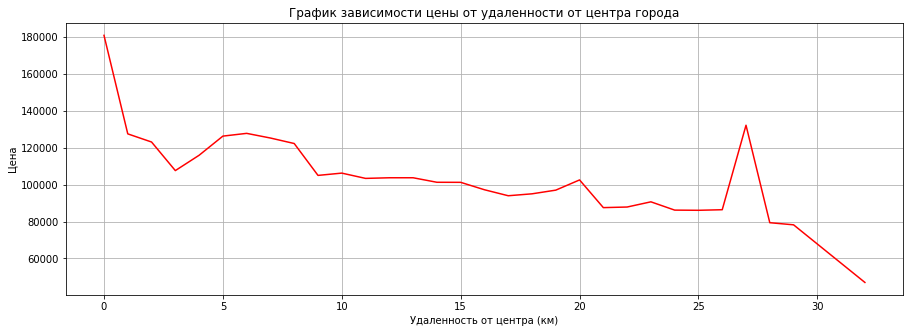

In [114]:
# график зависимости цены от удаления от центра (кровью напишем, уж много слишком проект её выпил и непонятно, сколько еще попьёт).
st_peter_dis_cost.plot(x = 'center_dist_km', y = 'mean_sq_meter_price', grid = True, color = 'red', figsize = (15, 5)) 
plt.xlabel('Удаленность от центра (км)')
plt.ylabel('Цена')
plt.title('График зависимости цены от удаленности от центра города')
plt.show()

Вывод: График подтверждает наличие зависимости цены от удаленности от центра, и снова, всё как в жизни. Есть аномалия в районе 27 км от центра, может быть что-то элитное? коттеджный поселок к примеру.

### Напишите общий вывод

Проведено исследование архива данных по продаже квартир в Санкт-Петербурге и Ленинградской области.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных.
На этапе предобработки данных были выявлены пропуски и некоторые ошибки при заполнении данных пользователем и выгрузке автоматических данных. Они по ситуации и по возможности были заполнены, исправлены или удалены.
Основная проблема при выгрузке данных - очень много пропусков в картографических данных (расстояние до центра, аэропорта, ближайшего парка и водоёма). Людям которые отвечают за ПО по этому вопросу необходимо в обязательном порядке принять меры для исправления технической ошибки.

В результате анализа данных было выявлено, что:
- 2 комнатные квартиры площадью около 50 м2 на 5-10 этаже в спальном районе - самые распространённые объекты продажи, вероятно, в виду их большого процента от общего объёма жилого фонда; 
- В среднем, время продажи квартиры составляет 2-3 месяца;
- на цену квартиры оказывает значительное влияние её площадь(как общая, так и жилая, в принципе, даже площадь кухни имеет значение в этом вопросе);
- по мере удаления от центра города средняя стоимость квартиры снижается;
- средняя стоимость квадратного метра на первом и последнем этажах ниже, чем на других этажах;
- на рассматриваемом временном промежутке средняя стоимость практически не зависит от даты публикации объявления, имеют место лишь поправки сезонность (летом спрос меньше - цена ниже), инфляцию (квартиры со временем как и всё остальное по определению дорожают) и внешнюю и внутреннюю обстановки в экономике.